In [37]:
# --- Instalasi dependensi utama (jalankan di Colab) ---
!pip install -q emoji Sastrawi transformers datasets accelerate evaluate scikit-learn

# --- Import umum ---
import re, html, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#TOKENISASI & N-GRAM
import re
import pandas as pd
from collections import Counter
from itertools import tee
from typing import List
# ML & evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#LOG-ODDS RATIO (MONROE) UNTUK RANKING KATA PER KELAS
from collections import defaultdict

# Teks Indonesia (opsional untuk baseline klasik)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Utils
import emoji
from tqdm import tqdm
tqdm.pandas()


In [38]:
#Ganti path jika perlu (Colab: upload file ke /content atau gunakan drive)
path = "/content/Dataset hasil scraping youtube comments.csv"  # sesuaikan jika berbeda
df = pd.read_csv(path)

# Pastikan kolom teks
TEXT_COL = "textDisplay"
assert TEXT_COL in df.columns, f"Kolom {TEXT_COL} tidak ditemukan. Kolom tersedia: {df.columns.tolist()}"

# Salin agar aman
data = df.copy()

print("Ukuran awal:", data.shape)
data.head()

Ukuran awal: (33830, 4)


,publishedAt,authorDisplayName,textDisplay,likeCount
0,2025-10-28T16:45:23Z,@nurrizkyna4877,Maaf om ded bilangin sama kabib2 minta tai nya...,0
1,2025-10-28T16:43:24Z,@nurrizkyna4877,Maaf om ded bilangin sama para habib nanti Kal...,0
2,2025-10-28T16:37:50Z,@revinaramdhani6408,Masyaallahh barakallahufikumm..<br>Do&#39;anya...,0
3,2025-10-28T16:39:54Z,@revinaramdhani6408,"Podcast yg luarbiasa masyallahh, banjir air ma...",0
4,2025-10-28T16:36:47Z,@nurrizkyna4877,Om ded maaf bilangin sama para habib kpn Mau m...,0


# **Preprosesing data**

In [39]:
data = df.copy()
# Dedup berdasarkan isi komentar
before = len(data)
data = data.drop_duplicates(subset=[TEXT_COL]).reset_index(drop=True)
print(f"Dedup: {before} -> {len(data)} baris")

# Pola regex umum
url_pat = re.compile(r'https?://\S+|www\.\S+')
mention_pat = re.compile(r'@\w+')
hashtag_pat = re.compile(r'#\w+')

def normalize_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = html.unescape(str(s))                 # unescape HTML entity (&amp; dll)
    s = s.lower()                              # lowercase
    s = url_pat.sub(' ', s)                    # hapus URL
    s = mention_pat.sub(' ', s)                # hapus @mention
    s = hashtag_pat.sub(' ', s)                # hapus #hashtag (teksnya sekalian dihapus)
    s = unicodedata.normalize("NFKC", s)       # normalisasi unicode
    s = re.sub(r'(.)\1{2,}', r'\1\1', s)       # kompres karakter berulang "baguuuus" -> "baguus"
    s = re.sub(r'\s+', ' ', s).strip()         # rapikan spasi
    return s

data["text_clean"] = data[TEXT_COL].astype(str).apply(normalize_text)

# Hapus baris kosong setelah cleaning
before = len(data)
data = data[data["text_clean"].str.strip() != ""].reset_index(drop=True)
print(f"Hapus kosong setelah cleaning: {before} -> {len(data)}")

data[[TEXT_COL, "text_clean"]].head(10)


Dedup: 33830 -> 30089 baris
Hapus kosong setelah cleaning: 30089 -> 30083


,textDisplay,text_clean
0,Maaf om ded bilangin sama kabib2 minta tai nya...,maaf om ded bilangin sama kabib2 minta tai nya...
1,Maaf om ded bilangin sama para habib nanti Kal...,maaf om ded bilangin sama para habib nanti kal...
2,Masyaallahh barakallahufikumm..<br>Do&#39;anya...,masyaallahh barakallahufikumm..<br>do'anya sem...
3,"Podcast yg luarbiasa masyallahh, banjir air ma...","podcast yg luarbiasa masyallahh, banjir air ma..."
4,Om ded maaf bilangin sama para habib kpn Mau m...,om ded maaf bilangin sama para habib kpn mau m...
5,Di arab aja diblacklist. Knp org indo mengagun...,di arab aja diblacklist. knp org indo mengagun...
6,Semoga saya segera d kasih keturunan aammiin,semoga saya segera d kasih keturunan aammiin
7,iru orang mana emang? gabisa bahasa indonesia ya?,iru orang mana emang? gabisa bahasa indonesia ya?
8,Semogaaa semuaaa pejuang garis duaa segera di ...,semogaa semuaa pejuang garis duaa segera di be...
9,Masyallah gacor,masyallah gacor


In [40]:
# FILTER TEKS PENDEK
min_words = 2  # ubah jadi 1 kalau mau lebih longgar
before = len(data)
data = data[data["text_clean"].str.split().str.len() >= min_words].reset_index(drop=True)
print(f"Filter teks < {min_words} kata: {before} -> {len(data)}")


Filter teks < 2 kata: 30083 -> 28634


In [41]:
# Jika belum ada, set data = df yang sudah punya 'text_clean'
assert "text_clean" in data.columns

# Stopwords ringkas Bahasa Indonesia (bisa kamu tambah)
STOPWORDS = {
    "yang","dan","di","ke","dari","ini","itu","untuk","atau","dengan","pada","kalo","kalau",
    "ya","iya","sih","deh","dong","lah","pun","nih","tuh","aja","cuma","doang","udah","udahh",
    "sama","kita","kami","aku","kamu","lu","gua","gue","dia","mereka","saya","anda",
    "tak","ku","mu","nya","punya","ada","jadi","karena","bisa","akan","kayak","gitu","gini"
}

def tokenize(text: str):
    # keep huruf/angka, split spasi
    t = re.sub(r"[^0-9a-zA-Z\u00C0-\u024F\u1E00-\u1EFF]+", " ", text)  # Latin + aksen
    t = re.sub(r"\s+", " ", t).strip().lower()
    toks = [w for w in t.split() if len(w) >= 2 and w not in STOPWORDS]
    return toks

def bigrams(tokens):
    a, b = tee(tokens)
    next(b, None)
    return list(zip(a, b))

# Tokenisasi seluruh korpus
data["tokens"] = data["text_clean"].apply(tokenize)
data["bigrams"] = data["tokens"].apply(bigrams)

# Frekuensi global
uni_counter = Counter()
bi_counter  = Counter()
for toks, bis in zip(data["tokens"], data["bigrams"]):
    uni_counter.update(toks)
    bi_counter.update(bis)

# Lihat kandidat top
top_unigrams = uni_counter.most_common(50)
top_bigrams  = bi_counter.most_common(50)

print("Top 20 unigram:\n", top_unigrams[:20])
print("\nTop 20 bigram:\n", top_bigrams[:20])


Top 20 unigram:
 [('allah', 8493), ('habib', 8358), ('br', 7785), ('om', 6330), ('yg', 5698), ('umar', 5310), ('semoga', 4973), ('podcast', 4352), ('ded', 3602), ('beliau', 3268), ('aamiin', 2596), ('semua', 2372), ('orang', 2181), ('masyaallah', 2104), ('muhammad', 2079), ('bin', 1796), ('dedy', 1731), ('selalu', 1726), ('masya', 1723), ('nabi', 1656)]

Top 20 bigram:
 [(('habib', 'umar'), 4666), (('om', 'ded'), 3226), (('br', 'br'), 1600), (('masya', 'allah'), 1516), (('umar', 'bin'), 1366), (('bin', 'hafidz'), 1176), (('habib', 'jindan'), 857), (('om', 'dedy'), 818), (('allah', 'swt'), 816), (('sayyidina', 'muhammad'), 705), (('luar', 'biasa'), 626), (('nabi', 'muhammad'), 616), (('air', 'mata'), 586), (('podcast', 'terbaik'), 582), (('semoga', 'allah'), 576), (('om', 'dedi'), 566), (('om', 'deddy'), 563), (('sehat', 'selalu'), 485), (('br', 'semoga'), 449), (('umar', 'habib'), 422)]


In [42]:
# Lexicon (lengkapi sesuai domain kamu)
POS_WORDS = set("""
bagus akhlak Yaa Rosuulalloh baik mantap mantappp suka keren top rekomendasi rekomen puas terharu allah memuaskan membantu jelas Tanda kewalian paham salut hebat wow tanda kewalian dakwah beruntung takdir
terbaik mantull mantapluar dihormati agama softspoken menenagkan biasa mantul palestina gokil masyaallah alhadulillah membimbing umat berkah habib umar bin hafidz hati tenang doa guru besar ulama
""".split())

NEG_WORDS = set("""
jelek buruk parah kecewa kecewanya kecewinya enggak gak tidak payah kacau sampah bohong hoax tipu mengecewakan lambat ngibul baalwi
buruk sekali aneh useless ga guna nggak guna ga jelas tidak jelas wahabi hujat kadrun anis bidah pendonggeng dongeng cari nama pamor gacor
""".split())

NEGATIONS = {
    "tidak","nggak","gak","enggak","bukan","kurang","tak","nda","ndak","tdk","ga","ngga","engga","belum","no"
}

INTENSIFIERS = {"banget","sekali","sangat","parah","bgt","banged","bngt","super","amat","lebih","bangetsih","parahsih"}
DIMINISHERS = {"agak","cukup","lumayan","sedikit","rada","agaklah"}

CONTRAST = {"tapi","namun","meski","meskipun","walau","walaupun","walaupunpun","walaupun"}

POS_EMOJI = set(list("😀😃😄😁😆😊🙂😢😭😍🤩👍❤️💯✨👏😇🥳❤💖💗💙💚💛💜👍🏻👍🏽👍🏾👍🏿"))
NEG_EMOJI = set(list("😞😟😠😡🤬👎💔🤮😤🙄😒👎🏻👎🏽👎🏾👎🏿"))

# Emoticon sederhana
POS_EMOTICONS = {":)", ":-)", ":D", ":-D", ";)", ";-)", "^_^"}
NEG_EMOTICONS = {":(", ":-(", ":'(", "T_T", ":-/", ":-|"}

# Pola frasa yang membalik polaritas negatif→positif, dan sebaliknya
PHRASE_POS = [
    r"\btidak\s+buruk\b", r"\bgak\s+buruk\b", r"\benggak\s+buruk\b",
    r"\bga\s+jelek\b", r"\btidak\s+jelek\b",
    r"\bparah\s+sih\s+keren(nya)?\b", r"\bgila\s+sih\b.*\b(keren|bagus|mantap)\b"
]
PHRASE_NEG = [
    r"\btidak\s+bagus\b", r"\bgak\s+bagus\b", r"\benggak\s+bagus\b",
    r"\bkurang\s+bagus\b", r"\bkurang\s+jelas\b"
]

phrase_pos_compiled = [re.compile(p) for p in PHRASE_POS]
phrase_neg_compiled = [re.compile(p) for p in PHRASE_NEG]

def _emoji_score(text: str) -> float:
    pos = sum(ch in POS_EMOJI for ch in text)
    neg = sum(ch in NEG_EMOJI for ch in text)
    # emoticons
    for emo in POS_EMOTICONS:
        pos += text.count(emo)
    for emo in NEG_EMOTICONS:
        neg += text.count(emo)
    return 0.5 * (pos - neg)   # bobot kecil-menengah

def _phrase_rules(text: str) -> float:
    t = " " + text + " "
    for p in phrase_pos_compiled:
        if p.search(t):
            return +1.0
    for p in phrase_neg_compiled:
        if p.search(t):
            return -1.0
    return 0.0

def _tokenize(text: str) -> List[str]:
    # tokenisasi sederhana: pisah spasi & hapus tanda baca ringan
    txt = re.sub(r"[^\w\s]", " ", text)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt.split()

def weak_label_v2(text: str,
                  neg_scope: int = 3,
                  base_weight: float = 1.0,
                  intensifier_gain: float = 1.6,
                  diminisher_gain: float = 0.6,
                  contrast_weight_after: float = 0.7,
                  neutral_threshold: float = 0.5) -> str:
    """Weak labeling dengan skor, scope negasi, intensifier/hedge, dan kontras."""
    if not isinstance(text, str) or not text.strip():
        return "netral"

    # Frasa spesial & emoji
    score = _phrase_rules(text)
    score += _emoji_score(text)

    toks = _tokenize(text.lower())
    n = len(toks)

    # Tentukan blok kontras (sebelum/ sesudah 'tapi/namun/…')
    if any(c in toks for c in CONTRAST):
        # ambil indeks kontras pertama
        idx = min([i for i,t in enumerate(toks) if t in CONTRAST])
        left = toks[:idx]
        right = toks[idx+1:]
    else:
        left, right = toks, []

    def span_score(span: List[str]) -> float:
        s = 0.0
        i = 0
        while i < len(span):
            tok = span[i]
            # deteksi negasi
            if tok in NEGATIONS:
                # balikan polaritas kata sentimen dalam jangkauan
                for j in range(1, neg_scope+1):
                    if i+j < len(span):
                        t2 = span[i+j]
                        if t2 in POS_WORDS:
                            s -= base_weight
                        elif t2 in NEG_WORDS:
                            s += base_weight
                i += 1
                continue

            # bobot dasar kata sentimen
            if tok in POS_WORDS:
                local = base_weight
                # intensifier / diminisher di sekitar
                if i+1 < len(span) and span[i+1] in INTENSIFIERS:
                    local *= intensifier_gain
                if i+1 < len(span) and span[i+1] in DIMINISHERS:
                    local *= diminisher_gain
                s += local

            elif tok in NEG_WORDS:
                local = base_weight
                if i+1 < len(span) and span[i+1] in INTENSIFIERS:
                    local *= intensifier_gain
                if i+1 < len(span) and span[i+1] in DIMINISHERS:
                    local *= diminisher_gain
                s -= local
            i += 1
        return s

    left_s  = span_score(left)
    right_s = span_score(right)

    # Jika ada kontras, beratkan klausa kanan
    if right:
        score += (1 - contrast_weight_after)*left_s + contrast_weight_after*right_s
    else:
        score += left_s

    # Keputusan label dengan ambang netral
    if score > neutral_threshold:
        return "positif"
    elif score < -neutral_threshold:
        return "negatif"
    else:
        return "netral"

# fungsi baru :
data["label"] = data["text_clean"].apply(weak_label_v2)

# distribusi setelah perbaikan
data["label"].value_counts(), (data["label"].value_counts(normalize=True)*100).round(2).astype(str) + "%"

(label
 positif    17622
 netral     10734
 negatif      278
 Name: count, dtype: int64,
 label
 positif    61.54%
 netral     37.49%
 negatif     0.97%
 Name: proportion, dtype: object)

In [43]:
#RANKING KATA PER KELAS

assert "label" in data.columns, "Butuh kolom 'label' dari weak labeling."

CLASSES = ["negatif","netral","positif"]

# Hitung count kata per kelas
counts = {c: Counter() for c in CLASSES}
for toks, lab in zip(data["tokens"], data["label"]):
    if lab in CLASSES:
        counts[lab].update(toks)

# Total per kelas & total keseluruhan
n_c = {c: sum(counts[c].values()) for c in CLASSES}
vocab = set().union(*[set(counts[c].keys()) for c in CLASSES])
V = len(vocab)
alpha = 0.01  # prior kecil agar stabil

def log_odds(word, c1, c2):
    # log-odds (wrt c1 vs c2) dengan smoothing alpha
    x1 = counts[c1][word] + alpha
    x2 = counts[c2][word] + alpha
    n1 = n_c[c1] + alpha*V
    n2 = n_c[c2] + alpha*V
    p1 = x1 / n1
    p2 = x2 / n2
    return np.log(p1/(1-p1 + 1e-12)) - np.log(p2/(1-p2 + 1e-12))

# Skor “kecenderungan” per kelas = rata-rata log-odds melawan dua kelas lain
scores = {c: {} for c in CLASSES}
for w in vocab:
    for c in CLASSES:
        others = [o for o in CLASSES if o != c]
        s = np.mean([log_odds(w, c, o) for o in others])
        scores[c][w] = float(s)

# Buat DataFrame kandidat leksikon
rows = []
for w in vocab:
    rows.append({
        "term": w,
        "freq_total": sum(counts[c][w] for c in CLASSES),
        "score_negatif": scores["negatif"][w],
        "score_netral":  scores["netral"][w],
        "score_positif": scores["positif"][w],
        "freq_negatif":  counts["negatif"][w],
        "freq_netral":   counts["netral"][w],
        "freq_positif":  counts["positif"][w],
    })

lex_df = pd.DataFrame(rows).sort_values("freq_total", ascending=False)
lex_df.head(10)


,term,freq_total,score_negatif,score_netral,score_positif,freq_negatif,freq_netral,freq_positif
21264,allah,8493,-1.421967,-2.033763,3.455731,5,66,8422
12458,habib,8358,-1.952560,-1.271053,3.223613,4,125,8229
19032,br,7785,0.199284,-0.461804,0.262520,93,1195,6497
7880,om,6330,-0.430088,0.316200,0.113888,49,1584,4697
7464,yg,5698,0.084217,-0.057912,-0.026305,70,1263,4365
20613,umar,5310,-2.373807,-1.815844,4.189650,1,29,5280
23857,semoga,4973,-1.693448,0.948820,0.744628,11,1253,3709
10206,podcast,4352,-0.916340,0.588941,0.327398,21,1125,3206
17402,ded,3602,-0.273428,0.291246,-0.017818,33,949,2620
15538,beliau,3268,-0.292070,-0.039034,0.331104,26,609,2633


In [44]:
# CEK DISTRIBUSI & CONTOH

print("Distribusi label (count):")
print(data["label"].value_counts())
print("\nDistribusi label (proporsi):")
print((data["label"].value_counts(normalize=True)*100).round(2).astype(str) + "%")



Distribusi label (count):
label
positif    17622
netral     10734
negatif      278
Name: count, dtype: int64

Distribusi label (proporsi):
label
positif    61.54%
netral     37.49%
negatif     0.97%
Name: proportion, dtype: object


# Explorasi data

In [45]:
# STATISTIK UMUM DATASET

print("Jumlah total data:", len(data))
print("\nJumlah data per label:")
print(data["label"].value_counts())

# Hitung panjang teks
data["char_len"] = data["text_clean"].str.len()
data["word_len"] = data["text_clean"].apply(lambda x: len(str(x).split()))

print("\nRata-rata panjang karakter:", round(data["char_len"].mean(), 2))
print("Rata-rata panjang kata:", round(data["word_len"].mean(), 2))

# Cek apakah ada data kosong
print("\nCek missing values:")
print(data.isnull().sum())


Jumlah total data: 28634

Jumlah data per label:
label
positif    17622
netral     10734
negatif      278
Name: count, dtype: int64

Rata-rata panjang karakter: 98.31
Rata-rata panjang kata: 15.12

Cek missing values:
publishedAt          0
authorDisplayName    2
textDisplay          0
likeCount            0
text_clean           0
tokens               0
bigrams              0
label                0
char_len             0
word_len             0
dtype: int64


/tmp/ipython-input-2824801271.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=data, palette="Set2", order=["negatif","netral","positif"])


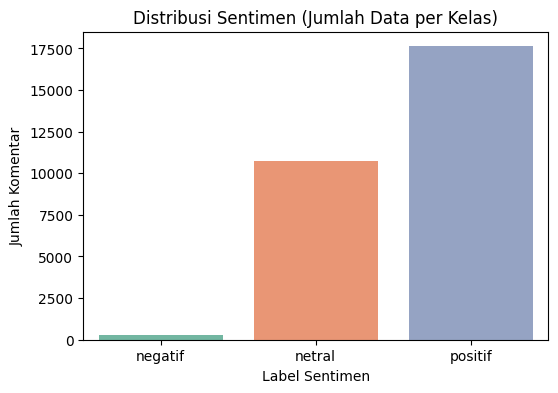

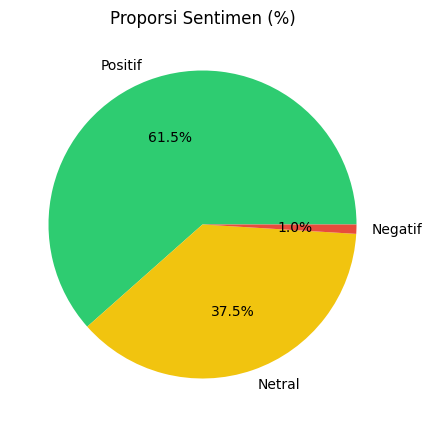

In [46]:
#DISTRIBUSI LABEL (GRAFIK)

plt.figure(figsize=(6,4))
sns.countplot(x="label", data=data, palette="Set2", order=["negatif","netral","positif"])
plt.title("Distribusi Sentimen (Jumlah Data per Kelas)")
plt.xlabel("Label Sentimen")
plt.ylabel("Jumlah Komentar")
plt.show()

# Pie chart
plt.figure(figsize=(5,5))
data["label"].value_counts().plot.pie(autopct='%1.1f%%', colors=["#2ECC71","#F1C40F","#E74C3C"], labels=["Positif","Netral","Negatif"])
plt.title("Proporsi Sentimen (%)")
plt.ylabel("")
plt.show()


In [47]:
# SAMPEL KOMENTAR PER KELAS
for lbl in ["negatif","netral","positif"]:
    print(f"\n=== Contoh komentar kelas {lbl.upper()} ===")
    sample = data[data["label"] == lbl].sample(min(5, (data["label"] == lbl).sum()), random_state=42)
    display(sample[["text_clean","label"]])



=== Contoh komentar kelas NEGATIF ===


,text_clean,label
2345,"andai saya kaya raya. saya ingin ke finlandia,...",negatif
11896,"plat ""g"" yahudi azkenazi penipu alus lebih ber...",negatif
20224,bolong2?? kalian mengagung2kan orang yg menyel...,negatif
13803,aah bohong lu ded sampe nangis nangis,negatif
26107,jangan aneh tentang politik di indonesia.<br><...,negatif



=== Contoh komentar kelas NETRAL ===


,text_clean,label
11441,nonton satu jam lebih kayak lima menit bae .ma...,netral
16485,sahabat nabi pun perlu proses panjang untuk be...,netral
16985,masya alloh🥺,netral
16296,"<a href="" sambil nonton iseng maen di berkah99...",netral
3200,do'akan saya kawan semuanya agar masalah yg sa...,netral



=== Contoh komentar kelas POSITIF ===


,text_clean,label
11486,"maashaallahh, om dedy lebih banyak lagi ya, me...",positif
19365,bib istri saya lagi hamil.dan bermimpi dengan ...,positif
185,masya allah merupakan salah satu nikmat meliha...,positif
1740,"masya allah, semoga allah istiqamahkan om ded ...",positif
541,secara tidak sadar banyak sunah rosul diterapk...,positif


##Skema Eksperimen Pelatihan Model
| **Eksperimen** | **Algoritma**                | **Ekstraksi Fitur** | **Rasio Data (Train/Test)** | **Tujuan**                                                                                                                                                                                |
| -------------- | ---------------------------- | ------------------- | --------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **A**          | SVM (Support Vector Machine) | TF-IDF              | 80/20                       | Membangun model baseline klasik untuk membandingkan performa model lain dan menguji efektivitas representasi fitur berbasis frekuensi kata (TF-IDF).                                      |
| **B**          | Random Forest                | Word2Vec            | 70/30                       | Mengevaluasi kemampuan model berbasis ensemble dalam memanfaatkan representasi semantik (Word2Vec) untuk menangkap konteks makna antar kata dalam teks ulasan.                            |
| **C**          | Logistic Regression          | TF-IDF              | 80/20                       | Menguji pendekatan linear sederhana berbasis TF-IDF yang efisien secara komputasi namun tetap kompetitif dalam akurasi, guna melihat keseimbangan antara kinerja dan kecepatan pelatihan. |



In [48]:
# SPLIT DATA UNTUK EKSPERIMEN

# Stratified split supaya proporsi label seimbang
train_df, test_df = train_test_split(
    data,
    test_size=0.2,
    stratify=data["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["label"],
    random_state=42
)

print("Train set:", len(train_df))
print("Validation set:", len(val_df))
print("Test set:", len(test_df))
print("\nDistribusi label di train:")
print(train_df["label"].value_counts(normalize=True).round(3))


Train set: 20616
Validation set: 2291
Test set: 5727

Distribusi label di train:
label
positif    0.615
netral     0.375
negatif    0.010
Name: proportion, dtype: float64


# Eksperimen A – TF-IDF + SVM (Baseline Model)

In [49]:
# PERSIAPAN DATA
from sklearn.preprocessing import LabelEncoder

# Pastikan variabel train_df, val_df, test_df sudah ada dari tahap sebelumnya
le = LabelEncoder()
le.fit(data["label"])

y_train = le.transform(train_df["label"])
y_val   = le.transform(val_df["label"])
y_test  = le.transform(test_df["label"])

print("Mapping Label:")
print(dict(zip(le.classes_, le.transform(le.classes_))))


Mapping Label:
{'negatif': np.int64(0), 'netral': np.int64(1), 'positif': np.int64(2)}


In [50]:
# TF-IDF VECTORISATION
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,      # 10k fitur kata
    ngram_range=(1,2),       # unigram + bigram
    min_df=3,                # muncul di ≥3 dokumen
    max_df=0.9,              # abaikan kata terlalu umum
    sublinear_tf=True
)

X_train = tfidf.fit_transform(train_df["text_clean"])
X_val   = tfidf.transform(val_df["text_clean"])
X_test  = tfidf.transform(test_df["text_clean"])

print("Ukuran fitur:", X_train.shape)


Ukuran fitur: (20616, 10000)


In [51]:
# TRAIN SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

# Evaluasi
y_pred_train = svm_model.predict(X_train)
y_pred_test  = svm_model.predict(X_test)

print("Akurasi Train:", round(accuracy_score(y_train, y_pred_train)*100, 2), "%")
print("Akurasi Test :", round(accuracy_score(y_test, y_pred_test)*100, 2), "%")


Akurasi Train: 96.56 %
Akurasi Test : 91.58 %



Classification Report:

              precision    recall  f1-score   support

     negatif       0.65      0.20      0.30        56
      netral       0.85      0.94      0.89      2147
     positif       0.96      0.91      0.94      3524

    accuracy                           0.92      5727
   macro avg       0.82      0.68      0.71      5727
weighted avg       0.92      0.92      0.91      5727

F1-Macro: 0.711


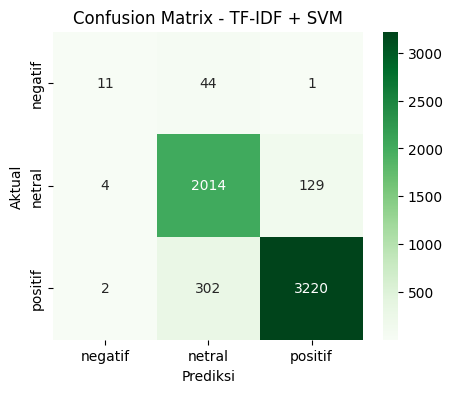

In [52]:
# EVALUASI DETAIL
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

# F1-Macro Score
f1_macro = f1_score(y_test, y_pred_test, average='macro')
print("F1-Macro:", round(f1_macro, 3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - TF-IDF + SVM")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


In [53]:
# INFERENCE
def predict_sentiment_svm(texts):
    X_new = tfidf.transform(texts)
    preds = svm_model.predict(X_new)
    return le.inverse_transform(preds)

# Contoh prediksi
samples = [
    "dasar wahabi",
    "masyaallah kapan bisa ketemu habib",
    "next undang lagi om ded"
]

preds = predict_sentiment_svm(samples)
for t, p in zip(samples, preds):
    print(f"{t} --> {p}")


dasar wahabi --> negatif
masyaallah kapan bisa ketemu habib --> positif
next undang lagi om ded --> netral


# Eksperimen B – Word2Vec + Random Forest

In [54]:
#SETUP & ENCODING LABEL
!pip install -q gensim

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Jika belum ada encoder dari eksperimen A, buat baru
try:
    le
except NameError:
    le = LabelEncoder().fit(data["label"])

y_train = le.transform(train_df["label"])
y_val   = le.transform(val_df["label"])
y_test  = le.transform(test_df["label"])

print("Mapping Label:", dict(zip(le.classes_, le.transform(le.classes_))))


Mapping Label: {'negatif': np.int64(0), 'netral': np.int64(1), 'positif': np.int64(2)}


In [55]:
# ====== 2) TOKENISASI UNTUK W2V ======
import re

def simple_tokenize(text: str):
    t = re.sub(r"[^0-9a-zA-Z\u00C0-\u024F\u1E00-\u1EFF]+", " ", str(text).lower())
    t = re.sub(r"\s+", " ", t).strip()
    return [w for w in t.split() if len(w) >= 2]

train_tokens = train_df["text_clean"].apply(simple_tokenize).tolist()
val_tokens   = val_df["text_clean"].apply(simple_tokenize).tolist()
test_tokens  = test_df["text_clean"].apply(simple_tokenize).tolist()

len(train_tokens), len(val_tokens), len(test_tokens)


(20616, 2291, 5727)

In [56]:
#TRAIN WORD2VEC
from gensim.models import Word2Vec

w2v_size = 300    # dimensi vektor
w2v_win  = 5      # jendela konteks
w2v_min  = 3      # kata minimal muncul
w2v_sg   = 1      # 1: skip-gram (umumnya lebih baik), 0: CBOW

w2v = Word2Vec(
    sentences=train_tokens,
    vector_size=w2v_size,
    window=w2v_win,
    min_count=w2v_min,
    workers=4,
    sg=w2v_sg,
    epochs=5
)
print("Vocab size:", len(w2v.wv))


Vocab size: 6664


In [57]:
# ====== 4) DOKUMEN → VEKTOR (AVERAGE W2V)
import numpy as np

def doc_vector(tokens, model, size=300):
    # rata-rata vektor kata yang ada di vocab; jika semua OOV -> nol
    vs = [model.wv[w] for w in tokens if w in model.wv]
    if len(vs) == 0:
        return np.zeros(size, dtype=np.float32)
    return np.mean(vs, axis=0).astype(np.float32)

X_train_w2v = np.vstack([doc_vector(t, w2v, w2v_size) for t in train_tokens])
X_val_w2v   = np.vstack([doc_vector(t, w2v, w2v_size) for t in val_tokens])
X_test_w2v  = np.vstack([doc_vector(t, w2v, w2v_size) for t in test_tokens])

X_train_w2v.shape, X_val_w2v.shape, X_test_w2v.shape


((20616, 300), (2291, 300), (5727, 300))

Akurasi Train: 99.07 %
Akurasi Test : 81.25 %

Classification Report (Test):
               precision    recall  f1-score   support

     negatif       1.00      0.05      0.10        56
      netral       0.79      0.70      0.74      2147
     positif       0.82      0.90      0.86      3524

    accuracy                           0.81      5727
   macro avg       0.87      0.55      0.57      5727
weighted avg       0.81      0.81      0.81      5727

F1-Macro (Test): 0.566


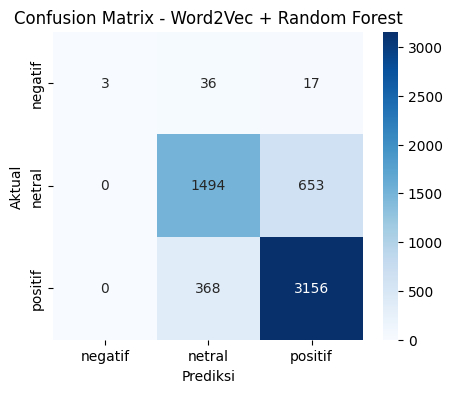

In [58]:
#TRAIN RANDOM FOREST + EVALUASI
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  # bantu kalau label agak timpang
)
rf.fit(X_train_w2v, y_train)

# Prediksi
y_pred_train = rf.predict(X_train_w2v)
y_pred_test  = rf.predict(X_test_w2v)

# Skor
print("Akurasi Train:", round(accuracy_score(y_train, y_pred_train)*100, 2), "%")
print("Akurasi Test :", round(accuracy_score(y_test,  y_pred_test )*100, 2), "%")
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test, target_names=le.classes_))
print("F1-Macro (Test):", round(f1_score(y_test, y_pred_test, average='macro'), 3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Word2Vec + Random Forest")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


In [67]:
#INFERENCE UNTUK WORD2VEC + RANDOM FOREST
def predict_sentiment_rf(texts):
    """
    Memprediksi sentimen menggunakan model Random Forest
    berbasis rata-rata Word2Vec embedding.
    """
    if isinstance(texts, str):
        texts = [texts]

    # Tokenisasi teks baru
    toks_list = [simple_tokenize(t) for t in texts]

    # Konversi ke vektor dokumen (average embedding)
    X_new = np.vstack([doc_vector(t, w2v, w2v_size) for t in toks_list])

    # Prediksi kelas
    preds = rf.predict(X_new)

    # Ubah ke label asli (positif, netral, negatif)
    return le.inverse_transform(preds)

# Contoh penggunaan
samples = [
    "dasar wahabi",
    "masyaallah kapan bisa ketemu habib",
    "next undang lagi om ded"
]

preds = predict_sentiment_rf(samples)
for t, p in zip(samples, preds):
    print(f"{t} --> {p}")


dasar wahabi --> netral
masyaallah kapan bisa ketemu habib --> positif
next undang lagi om ded --> netral


## Eksperimen C — Logistic Regression + TF-IDF

In [59]:
#ENCODE LABEL
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

try:
    le
except NameError:
    le = LabelEncoder().fit(pd.concat([train_df["label"], val_df["label"], test_df["label"]]))

y_train = le.transform(train_df["label"])
y_val   = le.transform(val_df["label"])
y_test  = le.transform(test_df["label"])

print("Label map:", dict(zip(le.classes_, le.transform(le.classes_))))


Label map: {'negatif': np.int64(0), 'netral': np.int64(1), 'positif': np.int64(2)}


In [60]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_lr = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

X_train_lr = tfidf_lr.fit_transform(train_df["text_clean"])
X_val_lr   = tfidf_lr.transform(val_df["text_clean"])
X_test_lr  = tfidf_lr.transform(test_df["text_clean"])

X_train_lr.shape, X_val_lr.shape, X_test_lr.shape


((20616, 10000), (2291, 10000), (5727, 10000))

In [61]:
#TRAIN LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

logre = LogisticRegression(
    C=2.0,
    max_iter=300,
    n_jobs=-1,
    class_weight=None
)
logre.fit(X_train_lr, y_train)

# Prediksi
y_pred_tr = logre.predict(X_train_lr)
y_pred_ts = logre.predict(X_test_lr)


Train Accuracy: 94.93 %
Test  Accuracy: 91.58 %
F1-Macro (Test): 0.672

Classification Report (Test):
               precision    recall  f1-score   support

     negatif       0.67      0.11      0.18        56
      netral       0.85      0.94      0.89      2147
     positif       0.96      0.91      0.94      3524

    accuracy                           0.92      5727
   macro avg       0.83      0.65      0.67      5727
weighted avg       0.92      0.92      0.91      5727



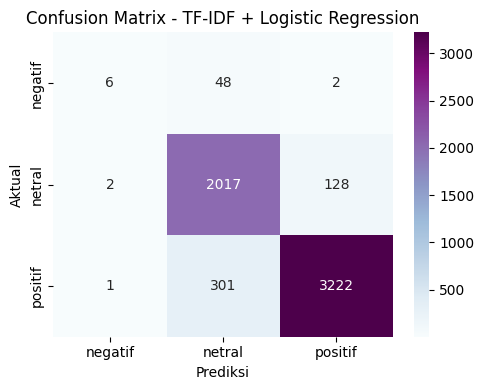

In [62]:
#EVALUASI
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Train Accuracy:", round(accuracy_score(y_train, y_pred_tr)*100, 2), "%")
print("Test  Accuracy:", round(accuracy_score(y_test,  y_pred_ts)*100, 2), "%")
print("F1-Macro (Test):", round(f1_score(y_test, y_pred_ts, average='macro'), 3))
print("\nClassification Report (Test):\n",
      classification_report(y_test, y_pred_ts, target_names=list(le.classes_)))

cm = confusion_matrix(y_test, y_pred_ts)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.xlabel("Prediksi"); plt.ylabel("Aktual")
plt.tight_layout(); plt.show()


In [68]:
#INFERENCE
def predict_sentiment_logre(texts):
    if isinstance(texts, str):
        texts = [texts]
    X = tfidf_lr.transform(texts)
    preds = logre.predict(X)
    return le.inverse_transform(preds)

samples = [
    "Kontennya jelas dan sangat membantu!",
    "Kurang informatif, bikin bingung.",
    "Biasa aja sih, lumayan tapi tidak istimewa."
]
preds = predict_sentiment_rf(samples)
for t, p in zip(samples, preds):
    print(f"{t} --> {p}")

Kontennya jelas dan sangat membantu! --> positif
Kurang informatif, bikin bingung. --> netral
Biasa aja sih, lumayan tapi tidak istimewa. --> positif


In [69]:
 pip freeze requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.1
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.0
altair==5.5.0
annotated-doc==0.0.3
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.10.20.0.39.8
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.0.1
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.3
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.26.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.10.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3